In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import osmnx as ox
import shapely as shp
from ast import literal_eval
from pyproj import Geod
import matplotlib.pyplot as plt
import folium

In [2]:
# somehwere in manhattan
loc = (40.73188892751728, -73.98927188478527)

In [3]:
# osmnx hospital count: 784
osmnx_hospitals = ox.geometries.geometries_from_# using the healthcare facility general information from the ny data website
ny_hospitals = pd.read_csv("data/Health_Facility_General_Information.csv")
ny_hospitals.columnspoint(loc, tags={"amenity": ["hospital", "clinic"]}, dist=32000)
osmnx_hospitals

geometry  \
element_type osmid                                                           
node         540400500                          POINT (-74.26669 40.67634)   
             1002534852                         POINT (-74.07083 40.71097)   
             2015849773                         POINT (-73.99342 40.68718)   
             2543331005                         POINT (-74.16253 40.59414)   
             2550589973                         POINT (-73.98930 40.66584)   
...                                                                    ...   
way          721524163   POLYGON ((-73.94347 40.65575, -73.94342 40.655...   
             753599730   POLYGON ((-73.97939 40.61643, -73.97916 40.616...   
             845192544   POLYGON ((-73.86782 40.65689, -73.86611 40.657...   
             1060381335  POLYGON ((-73.68522 40.67922, -73.68527 40.679...   
relation     3364740     POLYGON ((-73.91736 40.70463, -73.91739 40.704...   

                             addr:city addr:housenumber addr:postcode  \
element_type osmid                                                      
node         540400500           Union             1000         07083   
             1002534852            NaN              NaN           NaN   
             2015849773            NaN              203         11201   
             2543331005            NaN             2187         10314   
             2550589973            NaN              550         11215   
...                                ...              ...           ...   
way          721524163        Brooklyn              445         11203   
             753599730             NaN             6010         11204   
             845192544             NaN              NaN           NaN   
             1060381335  Valley Stream             1072         11580   
relation     3364740          Brooklyn              374         11237   

                                 addr:street   amenity beds emergency  \
element_type osmid                                                      
node         540400500   Galloping Hill Road    clinic   24       yes   
             1002534852                  NaN    clinic  NaN       NaN   
             2015849773         Court Street    clinic  NaN       NaN   
             2543331005      Richmond Avenue    clinic  NaN       NaN   
             2550589973           5th Avenue    clinic  NaN       NaN   
...                                      ...       ...  ...       ...   
way          721524163            Lenox Road  hospital  342       yes   
             753599730           Bay Parkway    clinic  NaN       NaN   
             845192544                   NaN  hospital  NaN       NaN   
             1060381335      Franklin Avenue    clinic  NaN       NaN   
relation     3364740        Stockholm Street  hospital  350       yes   

                                                                      name  \
element_type osmid                                                           
node         540400500          Overlook Emergency Services – Union Campus   
             1002534852                               Family Health Clinic   
             2015849773                                           Carecube   
             2543331005                                             CityMD   
             2550589973                                 Maimonides Doctors   
...                                                                    ...   
way          721524163                     University Hospital of Brooklyn   
             753599730                           Maimonides Medical Center   
             845192544   Brooklyn Developmental Disabilities Services O...   
             1060381335                              North Shore LIJ Annex   
relation     3364740                        Wyckoff Heights Medical Center   

                                   note  ... check_date:opening_hours  \
element_type osmid                       ...                   

In [28]:
# using the healthcare facility general information from the ny data website
ny_hospitals = pd.read_csv("data/Health_Facility_General_Information.csv")
ny_hospitals.columns

Index(['Facility ID', 'Facility Name', 'Short Description', 'Description',
       'Facility Open Date', 'Facility Address 1', 'Facility Address 2',
       'Facility City', 'Facility State', 'Facility Zip Code',
       'Facility Phone Number', 'Facility Fax Number', 'Facility Website',
       'Facility County Code', 'Facility County', 'Regional Office ID',
       'Regional Office', 'Main Site Name', 'Main Site Facility ID',
       'Operating Certificate Number', 'Operator Name', 'Operator Address 1',
       'Operator Address 2', 'Operator City', 'Operator State',
       'Operator Zip Code', 'Cooperator Name', 'Cooperator Address',
       'Cooperator Address 2', 'Cooperator City', 'Cooperator State',
       'Cooperator Zip Code', 'Ownership Type', 'Facility Latitude',
       'Facility Longitude', 'Facility Location'],
      dtype='object')

In [29]:
# list of general types of hospitals in this dataset
ny_hospitals["Description"].value_counts()

Licensed Home Care Services Agency                                       1433
Hospital Extension Clinic                                                1212
Diagnostic and Treatment Center Extension Clinic                          798
Residential Health Care Facility - SNF                                    621
Diagnostic and Treatment Center                                           579
Adult Home                                                                401
Hospital                                                                  226
School Based Hospital Extension Clinic                                    179
School Based Diagnostic and Treatment Center Extension Clinic             169
Enriched Housing Program                                                  153
Certified Home Health Agency                                              111
Mobile Diagnostic and Treatment Center Extension Clinic                    43
Hospice                                                         

In [30]:
# convert a latlon to a shapely point
def convert_to_point(row):
    if np.isnan(row["Facility Latitude"]):
        return shp.Point((0, 0))
    else:
        return shp.Point((float(row["Facility Longitude"]), float(row["Facility Latitude"])))

In [31]:
ny_hospitals["geometry"] = ny_hospitals.apply(lambda x: convert_to_point(x), axis=1)

In [33]:
# filter out only nyc hospoitals
geod = Geod(ellps="WGS84")

In [34]:
ny_hospitals["dist_from_nyc"] = ny_hospitals["geometry"].apply(lambda x: geod.geometry_length(shp.geometry.LineString([x, shp.Point((loc[1], loc[0]))])))
ny_hospitals["dist_from_nyc"].describe()

count    6.132000e+03
mean     6.712690e+05
std      2.035252e+06
min      3.503383e+02
25%      1.621973e+04
50%      8.244176e+04
75%      3.344734e+05
max      8.666418e+06
Name: dist_from_nyc, dtype: float64

In [36]:
# extract hospitals less than 32 km away from point in manhattan
nyc_hospitals = ny_hospitals[ny_hospitals["dist_from_nyc"] <= 32000]
nyc_hospitals

,Facility ID,Facility Name,Short Description,Description,Facility Open Date,Facility Address 1,Facility Address 2,Facility City,Facility State,Facility Zip Code,...,Cooperator Address 2,Cooperator City,Cooperator State,Cooperator Zip Code,Ownership Type,Facility Latitude,Facility Longitude,Facility Location,geometry,dist_from_nyc
2,1370,The Riverside,NH,Residential Health Care Facility - SNF,09/28/1981,150 Riverside Drive,NaN,New York,New York,10024,...,NaN,NaN,New York,NaN,LLC,40.790638,-73.979767,"(40.790638, -73.979767)",POINT (-73.97977 40.79064),6573.223217
7,6035,Barnabas Hospital Methadone,HOSP-EC,Hospital Extension Clinic,07/18/1996,4535-39 Third Avenue,NaN,Bronx,New York,10457,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.854229,-73.890892,"(40.854229, -73.890892)",POINT (-73.89089 40.85423),15922.181955
15,7769,Sheepshead Bay Surgery Center,DTC,Diagnostic and Treatment Center,06/17/1999,2269 Ocean Avenue,NaN,Brooklyn,New York,11229,...,NaN,NaN,New York,NaN,Business Corporation,40.606426,-73.952667,"(40.606426, -73.952667)",POINT (-73.95267 40.60643),14271.999184
17,9013,Mobile Medical Unit,NaN,Mobile Hospital Extension Clinic,02/20/2009,460 Brielle Avenue,NaN,Staten Island,New York,10314,...,NaN,NaN,New York,NaN,Municipality,40.593884,-74.135338,"(40.593884, -74.135338)",POINT (-74.13534 40.59388),19683.052686
23,9970,"Parkmed NYC, LLC",DTC,Diagnostic and Treatment Center,10/31/2016,"800 Second Avenue, 6th Floor",NaN,New York,New York,10017,...,NaN,NaN,New York,NaN,LLC,40.750033,-73.971612,"(40.750033, -73.971612)",POINT (-73.97161 40.75003),2506.923922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6110,1369,New York Congregational Nursing Center,NH,Residential Health Care Facility - SNF,01/01/1901,135 Linden Boulevard,NaN,Brooklyn,New York,11226,...,NaN,NaN,New York,NaN,LLC,40.652481,-73.953758,"(40.652481, -73.953758)",POINT (-73.95376 40.65248),9315.021923
6118,13109,"Hand In Hand Homecare, Llc",LHCSA,Licensed Home Care Services Agency,06/23/2015,4200 White Plains Road,Suite 101,Bronx,New York,10466,...,NaN,NaN,New York,NaN,LLC,40.893549,-73.856988,"(40.893549, -73.856988)",POINT (-73.85699 40.89355),21139.065049
6119,6844,Planned Parenthood Project Street Beat Mobile ...,NaN,Mobile Diagnostic and Treatment Center Extensi...,01/13/2006,26 Bleecker Street,NaN,New York,New York,10012,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.725521,-73.993538,"(40.725521, -73.993538)",POINT (-73.99354 40.72552),793.692451
6121,12832,Home Instead,LHCSA,Licensed Home Care Services Agency,07/28/2005,400 E 56th St,Professional Wing Ste 2,New York,New York,10022,...,NaN,NaN,New York,NaN,Business Corporation,40.757538,-73.963374,"(40.757538, -73.963374)",POINT (-73.96337 40.75754),3591.260274


In [40]:
# decent amount of entries, although not all are very relevant
nyc_hospitals["Description"].value_counts()

Licensed Home Care Services Agency                               696
Diagnostic and Treatment Center Extension Clinic                 377
Hospital Extension Clinic                                        300
Diagnostic and Treatment Center                                  247
Residential Health Care Facility - SNF                           203
School Based Hospital Extension Clinic                           122
School Based Diagnostic and Treatment Center Extension Clinic     96
Hospital                                                          80
Adult Home                                                        68
Enriched Housing Program                                          41
Certified Home Health Agency                                      39
Mobile Diagnostic and Treatment Center Extension Clinic           22
Adult Day Health Care Program - Offsite                           16
Long Term Home Health Care Program                                13
Hospice                           

### 1. Licensed Home Care Services Agency

(https://www.nyshcp.org/NYSHCP/NYSHCP/Finding_Home_Care_Tab/Types_of_Agencies.aspx)

Licensed home care services agencies (LHCSAs) offer home care services through personal care assistants, home health aides, nurses, and therapists, to patients that are covered by Medicaid or through private insurance. Services provided include homemaking, bathing, dressing, grooming, toileting, transferring from beds to chairs or wheelchairs, preparing meals, feeding, and routine skin care, among other services. LHCSAs may also subcontract with other home care providers to deliver services, particularly when delivering skilled care services through MLTC. LHCSAs may offer a full range of services from skilled to paraprofessional or may choose to focus on the delivery of one service or population, such as high-tech pediatrics or providing aides for seniors. 

In [63]:
nyc_hospitals[nyc_hospitals["Description"] == "Licensed Home Care Services Agency"].head(3)

,Facility ID,Facility Name,Short Description,Description,Facility Open Date,Facility Address 1,Facility Address 2,Facility City,Facility State,Facility Zip Code,...,Cooperator Address 2,Cooperator City,Cooperator State,Cooperator Zip Code,Ownership Type,Facility Latitude,Facility Longitude,Facility Location,geometry,dist_from_nyc
28,12532,Addus Homecare,LHCSA,Licensed Home Care Services Agency,06/01/2019,116-08 Myrtle Avenue,NaN,Richmond Hill,New York,11418,...,NaN,NaN,New York,NaN,Business Corporation,40.700107,-73.833305,"(40.700107, -73.833305)",POINT (-73.83330 40.70011),13642.877534
29,12551,Vista on 5th,LHCSA,Licensed Home Care Services Agency,08/25/2000,1261 Fifth Ave,NaN,New York,New York,10029-3822,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.795262,-73.949974,"(40.795262, -73.949974)",POINT (-73.94997 40.79526),7780.543891
59,12712,"Life Care Services, Inc.",LHCSA,Licensed Home Care Services Agency,06/20/2007,1723 Avenue M,NaN,Brooklyn,New York,11230-5303,...,NaN,NaN,New York,NaN,Business Corporation,40.618307,-73.957924,"(40.618307, -73.957924)",POINT (-73.95792 40.61831),12888.456953


Examples

Addus Homecare (https://addus.com/home-community/)

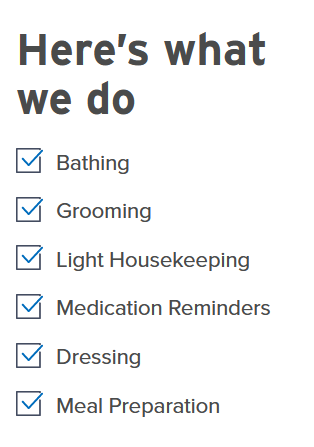

Vista on 5th (https://vistaon5th.org/)

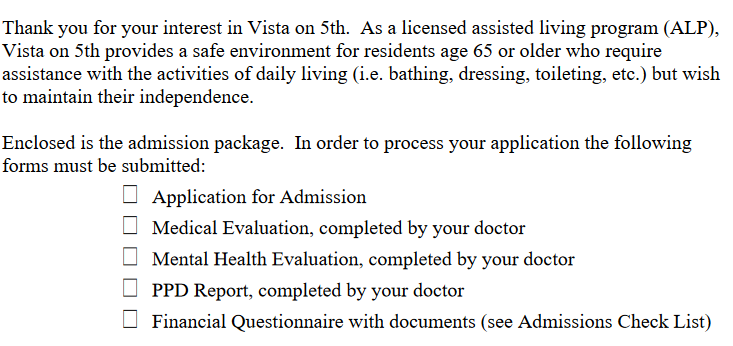

Life Care Services, Inc. (https://www.lifecareadvantage.net/)

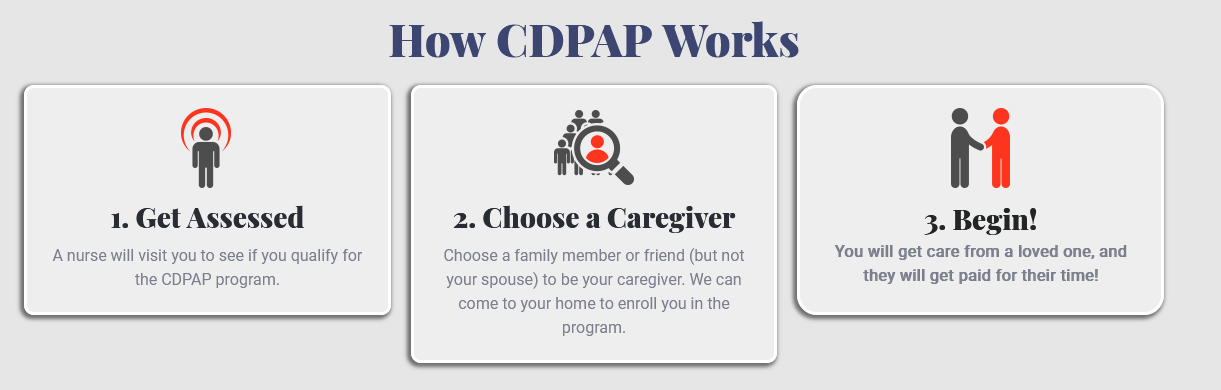

#### Summary

It seems that most facilities within this category cater mostly towards accomodating senior citizens in the realm of assisted living, whether within a centralized facility or with a staff traveling from home to home. These facilities generally also seem to need applications and don't support on-demand/walk-in visits, so this category should likely be eliminated from consideration for healthcare accessibility.

### 2. Diagnostic and Treatment Center Extension Clinic

(https://www.nyc.gov/nycbusiness/description/diagnostic-and-treatment-center-clinic-operating-certificate)

Diagnostic and treatment centers need a certificate in New York State. This certificate is from the NYS Department of Health (NYSDOH). These centers provide a range of primary health care services, and may operate part- or full-time. They can be associated with a clinic or hospital. Centers need a Certificate of Need to be certified. Certificates of Need show that a service meets a public need, is run by qualified people, and is financially solvent. 

(https://govt.westlaw.com/nycrr/Document/I4ffd11cacd1711dda432a117e6e0f345?viewType=FullText&originationContext=documenttoc&transitionType=CategoryPageItem&contextData=(sc.Default))

The terms diagnostic center and treatment center, also referred to in this Article as a center, shall mean a medical facility with one or more organized health services not part of an inpatient hospital facility or vocational rehabilitation center primarily engaged in providing services and facilities to out-of-hospital or ambulatory patients by or under the supervision of a physician or, in the case of a dental service or dispensary, of a dentist, for the prevention, diagnosis and, in the case of a treatment center, treatment of human disease, pain, injury, deformity or physical condition, not including the individual or group private practice of medicine.

\
(https://govt.westlaw.com/nycrr/Document/I4fe34822cd1711dda432a117e6e0f345?transitionType=Default&contextData=%28sc.Default%29)

Extension clinic shall mean a clinic which is a component of a general hospital sponsored ambulatory care program, or a diagnostic and treatment center sponsored ambulatory care program, offering services of a nonemergent nature and located on premises other than those of the hospital or diagnostic and treatment center which operates it. An extension clinic of a hospital or diagnostic and treatment center may be certified to provide services, authorized to be provided by a diagnostic and treatment center, other than or in addition to the services provided at the sponsoring hospital or center.

In [86]:
nyc_hospitals[nyc_hospitals["Description"] == "Diagnostic and Treatment Center Extension Clinic"].head(3)

,Facility ID,Facility Name,Short Description,Description,Facility Open Date,Facility Address 1,Facility Address 2,Facility City,Facility State,Facility Zip Code,...,Cooperator Address 2,Cooperator City,Cooperator State,Cooperator Zip Code,Ownership Type,Facility Latitude,Facility Longitude,Facility Location,geometry,dist_from_nyc
40,6821,CenterLight Healthcare D&TC,DTC-EC,Diagnostic and Treatment Center Extension Clinic,11/17/2005,216 East 99th Street,NaN,New York,New York,10029,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.786346,-73.946281,"(40.786346, -73.946281)",POINT (-73.94628 40.78635),7053.330901
44,13979,NYU College of Dentistry - Brooklyn,DTC-EC,Diagnostic and Treatment Center Extension Clinic,10/22/2020,445 Albee Square West,NaN,Brooklyn,New York,11201,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.690733,-73.983278,"(40.690733, -73.983278)",POINT (-73.98328 40.69073),4598.276656
64,1653,Corona Health Center,DTC-EC,Diagnostic and Treatment Center Extension Clinic,09/27/1979,34-33 Junction Boulevard,NaN,Corona,New York,11372,...,NaN,NaN,New York,NaN,Municipality,40.754082,-73.872108,"(40.754082, -73.872108)",POINT (-73.87211 40.75408),10198.069806


#### Examples

##### CenterLight Healthcare

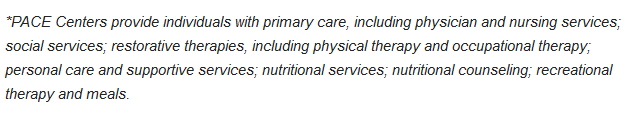

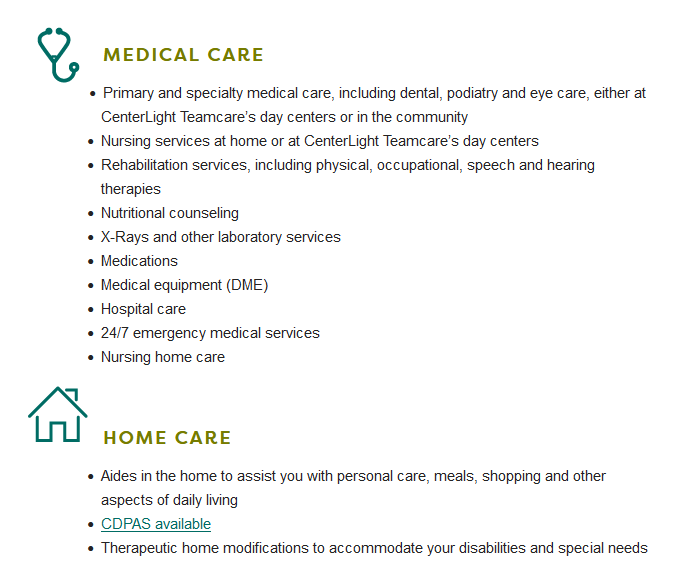

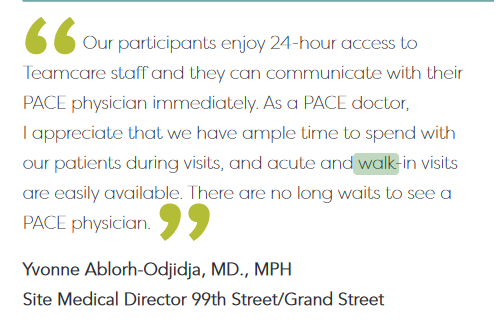

Appears to be like a centralized place for home care things; it is possible that you may need to register first before going. 

##### NYU Dentistry Brooklyn Patient Care

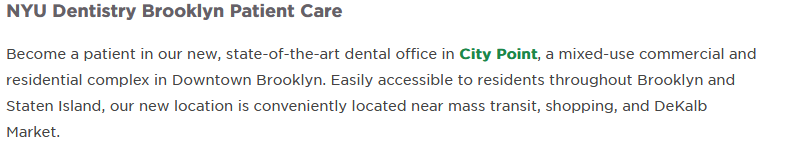

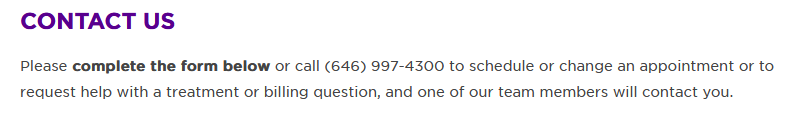

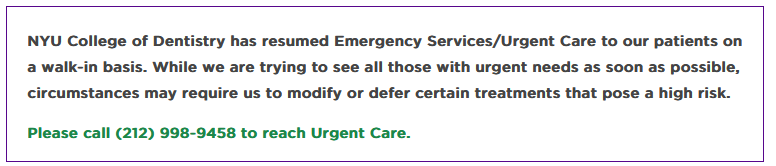

This is dentistry so not exactly primary care, but they do seem to offer emergency, walk-in visits (at least in the main branch).

##### Corona Health Center

There seem to be two healthcare facilities here, one operating under Gotham Heatlh (NYC + Health) and the other being a std clinic. The former says nothing about walk-ins but it is likely they accept them, and the latter does accept walk-ins

#### Summary

Diagnostic and Treatment Center Extension Clinics seem to vary in purpose/walk-in availability, but given the samples and their general description, they seem to be targeted towards primary care and should likely be included in the healthcare accessibility analysis.

### 3. Hospital Extension Clinic  

See definition of an extension clinic in #2, but apply it to a hospital instead.

In [87]:
nyc_hospitals[nyc_hospitals["Description"] == "Hospital Extension Clinic"].head(3)

,Facility ID,Facility Name,Short Description,Description,Facility Open Date,Facility Address 1,Facility Address 2,Facility City,Facility State,Facility Zip Code,...,Cooperator Address 2,Cooperator City,Cooperator State,Cooperator Zip Code,Ownership Type,Facility Latitude,Facility Longitude,Facility Location,geometry,dist_from_nyc
7,6035,Barnabas Hospital Methadone,HOSP-EC,Hospital Extension Clinic,07/18/1996,4535-39 Third Avenue,NaN,Bronx,New York,10457,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.854229,-73.890892,"(40.854229, -73.890892)",POINT (-73.89089 40.85423),15922.181955
83,3096,South Beach Psychiatric Center,HOSP-EC,Hospital Extension Clinic,09/19/1983,777 Seaview Avenue,NaN,Staten Island,New York,10305,...,NaN,New Hyde Park,New York,11042.0,Not for Profit Corporation,40.579605,-74.078171,"(40.579605, -74.078171)",POINT (-74.07817 40.57961),18506.682302
136,5550,NYU Langone Harkness Center for Dance Injuries,HOSP-EC,Hospital Extension Clinic,01/01/2006,614 Second Avenue,NaN,New York,New York,10016,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.744606,-73.975945,"(40.744606, -73.975945)",POINT (-73.97594 40.74461),1805.967674


#### Examples

##### Barnabas Hospital Methadone (sbhny.org, http://www.sbhny.org/wp-content/uploads/publications/Winter_2015/files/assets/common/downloads/page0005.pdf)

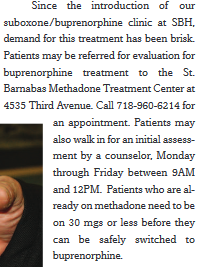

Possibly contains a more general clinic, but the metahdone clinic specializes in addiction care. 

##### South Beach Psychiatric Center (https://omh.ny.gov/omhweb/facilities/sbpc/)

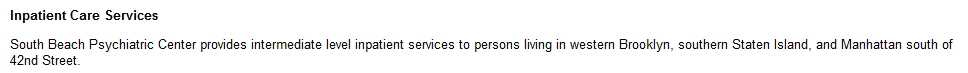

It is hard to tell whether they accept walk-ins/appointments at all, but they do provide inpatient care (seems to be like a mental hospital).

##### NYU Langone Harkness Center for Dance Injuries

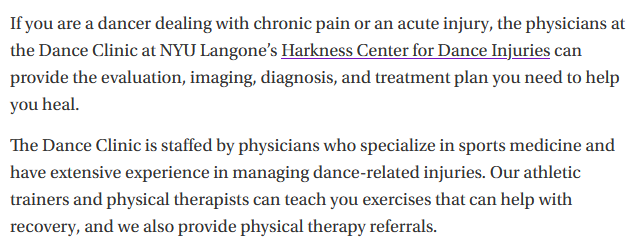

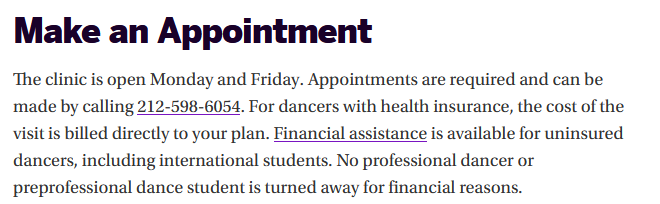

Very, very specialized; appointments don't seem to be that far into future (can make same-day).

#### Summary

Overall, like the previous section, hospital extension clinics vary greatly in purpose / walk-in availability (although it seems to be generally accessible), but they should likely be considered in healthcare accessibility.

### 4. Diagnostic and Treatment Center 

These are basically the main facilities of the diagnostic and treatment center extension clinics (see number 2).

In [90]:
nyc_hospitals[nyc_hospitals["Description"] == "Diagnostic and Treatment Center"].head(3)

,Facility ID,Facility Name,Short Description,Description,Facility Open Date,Facility Address 1,Facility Address 2,Facility City,Facility State,Facility Zip Code,...,Cooperator Address 2,Cooperator City,Cooperator State,Cooperator Zip Code,Ownership Type,Facility Latitude,Facility Longitude,Facility Location,geometry,dist_from_nyc
15,7769,Sheepshead Bay Surgery Center,DTC,Diagnostic and Treatment Center,06/17/1999,2269 Ocean Avenue,NaN,Brooklyn,New York,11229,...,NaN,NaN,New York,NaN,Business Corporation,40.606426,-73.952667,"(40.606426, -73.952667)",POINT (-73.95267 40.60643),14271.999184
23,9970,"Parkmed NYC, LLC",DTC,Diagnostic and Treatment Center,10/31/2016,"800 Second Avenue, 6th Floor",NaN,New York,New York,10017,...,NaN,NaN,New York,NaN,LLC,40.750033,-73.971612,"(40.750033, -73.971612)",POINT (-73.97161 40.75003),2506.923922
54,3136,Rogosin Kidney Center,DTC,Diagnostic and Treatment Center,11/01/1983,505 East 70th Street 2nd Fl,NaN,New York,New York,10021,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.765518,-73.954529,"(40.765518, -73.954529)",POINT (-73.95453 40.76552),4749.282651


#### Examples

##### Sheepshead Bay Surgery Center	 (https://sheepsheadbaysurgery.com/)

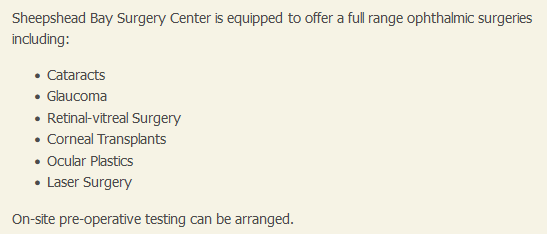

(eye care specialization)

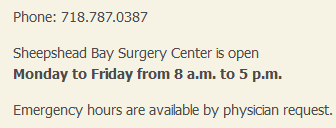

Nothing found about appointments but they probably need them (at least for surgeries)

##### ParkMed (https://parkmed.com/)

Their website is broken but it's an abortion clinic; you can schedule appointments but it is unclear whether it is necessary

##### Rogosin Kidney Center

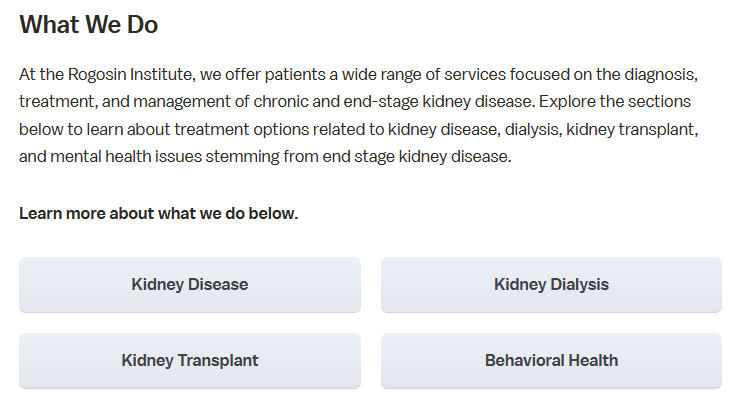

Unclear whether appointments are necessary but you can make them; it is possible this is case since dialysis isn't necessarily a walk-in thing.

#### Summary

Like the extension clinic category, these vary widely in purpose and whether they offer walk-in appointments, but they should probably be included in healthcare accessibility.

### 5. Residential Health Care Facility - SNF

A skilled nursing facility (SNF) is an inpatient rehabilitation and medical treatment center. They're often utilized for care after a hospital stay following an accident, severe illness, or surgery to help a patient regain their ability to do activities of daily living such as bathing, dressing, cooking, personal hygiene, walking, and getting into/out of a bed or chair. Similar to a nursing home, SNFs provide 24/7 care. Hebrew SeniorLife offers skilled nursing facilities at Hebrew Rehabilitation Center in Boston and at NewBridge on the Charles in Dedham. Our goal is to restore function following an illness or injury so older adults can get back to the people and activities that they love. 

It should be noted that the need for skilled nursing services does not automatically mean that you need a stay in an SNF since skilled nursing is available in a variety of settings including a senior’s private home. A number of factors will go into the decision about where to receive skilled nursing care, including your living situation, whether there is someone at home who can help you while you recover, the severity of your illness, and the types of rehab services you require.

Skilled nursing is mostly regulated by the Department of Public Health and the Centers for Medicare & Medicaid Services (CMS). To be certified by CMS and the DPH, skilled nursing communities must meet strict criteria and are subject to periodic inspections to ensure quality standards are being met. We are proud to say that the skilled nursing facilities at Hebrew Rehabilitation Center and Orchard Cove consistently receive five-star ratings from CMS and DPH.

(https://www.hebrewseniorlife.org/blog/difference-between-nursing-homes-and-skilled-nursing-facilities)

In [114]:
nyc_hospitals[nyc_hospitals["Description"] == "Residential Health Care Facility - SNF"].head(3)

,Facility ID,Facility Name,Short Description,Description,Facility Open Date,Facility Address 1,Facility Address 2,Facility City,Facility State,Facility Zip Code,...,Cooperator Address 2,Cooperator City,Cooperator State,Cooperator Zip Code,Ownership Type,Facility Latitude,Facility Longitude,Facility Location,geometry,dist_from_nyc
2,1370,The Riverside,NH,Residential Health Care Facility - SNF,09/28/1981,150 Riverside Drive,NaN,New York,New York,10024,...,NaN,NaN,New York,NaN,LLC,40.790638,-73.979767,"(40.790638, -73.979767)",POINT (-73.97977 40.79064),6573.223217
41,1218,Beth Abraham Center for Rehabilitation and Nur...,NH,Residential Health Care Facility - SNF,01/01/1901,612 Allerton Avenue,NaN,Bronx,New York,10467,...,NaN,NaN,New York,NaN,LLC,40.865292,-73.870010,"(40.865292, -73.87001)",POINT (-73.87001 40.86529),17909.855319
149,1704,Midway Nursing Home,NH,Residential Health Care Facility - SNF,01/01/1901,69-95 Queens Midtown Expressway,NaN,Maspeth,New York,11378,...,NaN,NaN,New York,NaN,Business Corporation,40.726330,-73.890694,"(40.72633, -73.890694)",POINT (-73.89069 40.72633),8350.580172


#### examples

##### Riverside (https://theriversiderehab.com/about/welcome-to-the-riverside/)

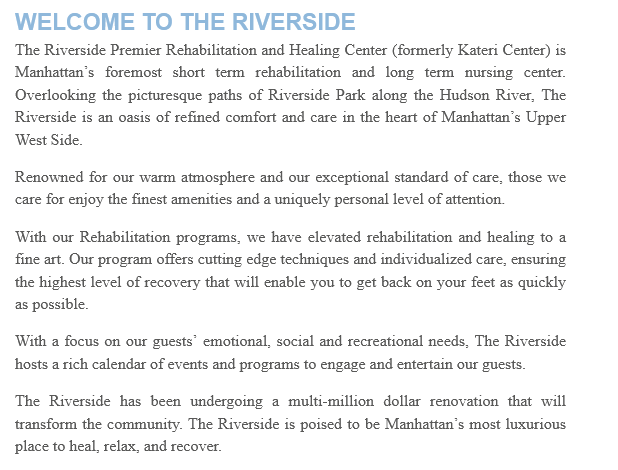

##### Beth Abraham (https://beth-abraham-center.facilities.centershealthcare.org/health-services/)

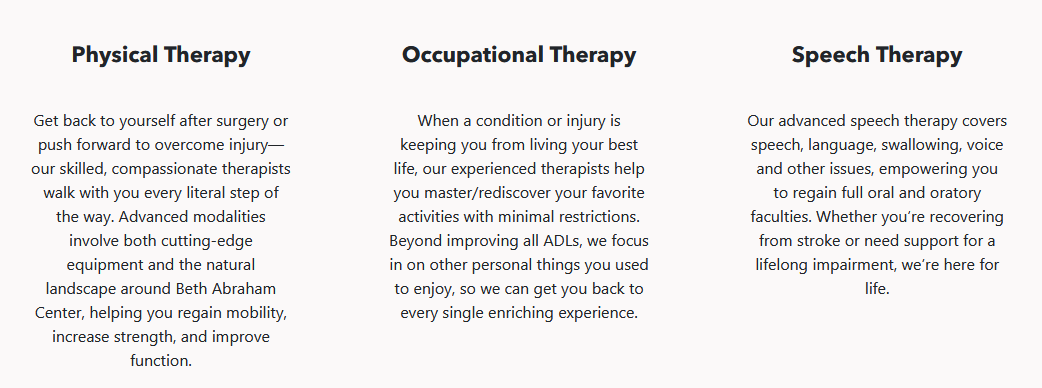

##### Midway Nursing Home

Nursing home


#### Summary

Ovearll, the facilities in this category are mostly nursing homes/rehab centers and aren't relevant to a person looking for immedaite medical care. Therefore, we exclude these faciltiies from healthcare accessibility consideration. 

### 6/7. School Based Hospital Extension Clinic/Diagnostic and Treatment Center Extension Clinics

School-Based Health Centers are medical health centers within the schools. They help students manage their illnesses during the school day. Because of the location, School Based Health Center are an easy health care option for busy students with busy parents who cannot always make it to their doctor’s office.

In [116]:
nyc_hospitals[nyc_hospitals["Description"] == "School Based Hospital Extension Clinic"].head(3)

,Facility ID,Facility Name,Short Description,Description,Facility Open Date,Facility Address 1,Facility Address 2,Facility City,Facility State,Facility Zip Code,...,Cooperator Address 2,Cooperator City,Cooperator State,Cooperator Zip Code,Ownership Type,Facility Latitude,Facility Longitude,Facility Location,geometry,dist_from_nyc
58,10360,PS 171 Patrick Henry Preparatory School,HOSP-SB,School Based Hospital Extension Clinic,09/20/2019,19 East 103rd Street,NaN,New York,New York,10029,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.792294,-73.951449,"(40.792294, -73.951449)",POINT (-73.95145 40.79229),7429.393063
68,6301,PS 155,HOSP-SB,School Based Hospital Extension Clinic,03/01/2001,130-02 115th Ave,NaN,South Ozone Park,New York,11420,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.679634,-73.810173,"(40.679634, -73.810173)",POINT (-73.81017 40.67963),16209.587796
75,4620,PS 83 Mendoza School,HOSP-SB,School Based Hospital Extension Clinic,07/01/1992,219 East 109th Street,NaN,New York,New York,10029,...,NaN,New York,New York,10029.0,Not for Profit Corporation,40.792862,-73.941612,"(40.792862, -73.941612)",POINT (-73.94161 40.79286),7876.622758


In [118]:
nyc_hospitals[nyc_hospitals["Description"] == "School Based Diagnostic and Treatment Center Extension Clinic"].head(3)

,Facility ID,Facility Name,Short Description,Description,Facility Open Date,Facility Address 1,Facility Address 2,Facility City,Facility State,Facility Zip Code,...,Cooperator Address 2,Cooperator City,Cooperator State,Cooperator Zip Code,Ownership Type,Facility Latitude,Facility Longitude,Facility Location,geometry,dist_from_nyc
47,6881,PS 457,NaN,School Based Diagnostic and Treatment Center E...,04/17/2006,1116 Sheridan Avenue,NaN,Bronx,New York,10456,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.832100,-73.917831,"(40.8321, -73.917831)",POINT (-73.91783 40.83210),12657.322873
93,6200,C.I.S. 303,NaN,School Based Diagnostic and Treatment Center E...,09/01/1998,1700 Macombs Rd,NaN,Bronx,New York,10453,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.849052,-73.916054,"(40.849052, -73.916054)",POINT (-73.91605 40.84905),14403.918634
233,10161,850 Grand St Campus High School,NaN,School Based Diagnostic and Treatment Center E...,07/01/2018,850 Grand Street,NaN,Brooklyn,New York,11211,...,125 Worth Street,New York,New York,10013.0,Municipality,40.711045,-73.938995,"(40.711045, -73.938995)",POINT (-73.93900 40.71104),4837.528735


#### Summary

These facilities, being targeted towards students, aren't necessarily appliacble towards general healthcare accessibility, but they do apply very much to students, providing on-demand services for them. Whether or not these should be considered in healthcare accessibility is more up to debate.

### 8. Hospital

In [133]:
nyc_hospitals[nyc_hospitals["Description"] == "Hospital"].head(3)

,Facility ID,Facility Name,Short Description,Description,Facility Open Date,Facility Address 1,Facility Address 2,Facility City,Facility State,Facility Zip Code,...,Cooperator Address 2,Cooperator City,Cooperator State,Cooperator Zip Code,Ownership Type,Facility Latitude,Facility Longitude,Facility Location,geometry,dist_from_nyc
77,1186,North Central Bronx Hospital,HOSP,Hospital,01/01/1901,3424 Kossuth Avenue & 210th Street,NaN,Bronx,New York,10467,...,NaN,NaN,New York,NaN,Municipality,40.880512,-73.881538,"(40.880512, -73.881538)",POINT (-73.88154 40.88051),18842.589429
103,1469,Mount Sinai Morningside,HOSP,Hospital,01/01/1901,1111 Amsterdam Avenue,NaN,New York,New York,10025,...,NaN,New York,New York,10029.0,Not for Profit Corporation,40.805912,-73.961639,"(40.805912, -73.961639)",POINT (-73.96164 40.80591),8544.876635
126,10139,New York-Presbyterian David H. Koch Center,HOSP,Hospital,04/09/2018,1283 York Avenue,NaN,New York,New York,10065,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.764794,-73.955346,"(40.764794, -73.955346)",POINT (-73.95535 40.76479),4643.445778


#### Examples

##### North Central Bronx Hospital (https://www.nychealthandhospitals.org/north-central-bronx/patients-visitors/)

Associated wiht NYC Health + Hospitals (public system), supports appointments, although it is not stated whether they are required.

##### Mount Sinai Morningside

Supports same-day appointments but it is not stated whether appointments are necessary. 

##### New York Presbyterian David H. Koch Center

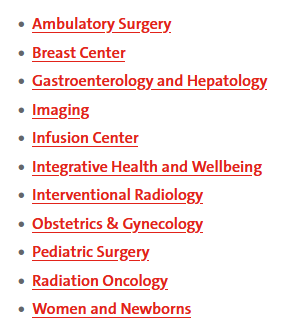

Nothing is really said about appointments.

#### Summary

Hospitals should probably be included into the healthcare accessibilty calculations; it is very likely that appointments are necessary but same-day appointments can realistlcally be handled, and hospitals are just generally the crux of healthcare. 

### 9. Adult Home

Adult homes are establishments that provide long-term residential care for five or more adults. The facility can also provide social day care, temporary care, or rehabilitative services. Facilities cannot provide nursing or medical care.

In [134]:
nyc_hospitals[nyc_hospitals["Description"] == "Adult Home"].head(3)

,Facility ID,Facility Name,Short Description,Description,Facility Open Date,Facility Address 1,Facility Address 2,Facility City,Facility State,Facility Zip Code,...,Cooperator Address 2,Cooperator City,Cooperator State,Cooperator Zip Code,Ownership Type,Facility Latitude,Facility Longitude,Facility Location,geometry,dist_from_nyc
46,14853,Inspir Carnegie Hill,AH,Adult Home,02/26/2021,1802 2nd Avenue,NaN,New York,New York,10128,...,NaN,NaN,New York,NaN,LLC,40.782372,-73.948109,"(40.782372, -73.948109)",POINT (-73.94811 40.78237),6596.248515
84,15125,The Fountains at RiverVue,AH,Adult Home,12/19/2001,1 Rivervue Place,NaN,Tuckahoe,New York,10707,...,NaN,NaN,New York,NaN,Business Corporation,40.952158,-73.828044,"(40.952158, -73.828044)",POINT (-73.82804 40.95216),27986.228274
413,14808,Plattduetsche Home Society,AH,Adult Home,04/06/1988,1150 Hempstead Turnpike,NaN,Franklin Square,New York,11010,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.708419,-73.683483,"(40.708419, -73.683483)",POINT (-73.68348 40.70842),25967.225326


#### Summary

These facilities are targeted twoards very specific groups that make arrangements before hand adn thus aren't applicable to broader helathcare accessibility1

### 10. Enriched Housing Program

These programs provide long-term residential care in independent housing units to older people. They cannot provide medical care. They can provide social day care, temporary care, and rehabilitative services. 

In [119]:
nyc_hospitals[nyc_hospitals["Description"] == "Enriched Housing Program"].head(3)

,Facility ID,Facility Name,Short Description,Description,Facility Open Date,Facility Address 1,Facility Address 2,Facility City,Facility State,Facility Zip Code,...,Cooperator Address 2,Cooperator City,Cooperator State,Cooperator Zip Code,Ownership Type,Facility Latitude,Facility Longitude,Facility Location,geometry,dist_from_nyc
80,14754,Assisted Living at Jennings Hall,EHP,Enriched Housing Program,08/18/2010,260 Powers Street,NaN,Brooklyn,New York,11211,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.712743,-73.940017,"(40.712743, -73.940017)",POINT (-73.94002 40.71274),4673.089675
308,14838,The Bristal at North Hills,EHP,Enriched Housing Program,03/31/2006,99 South Service Road,NaN,North Hills,New York,11040,...,NaN,NaN,New York,NaN,Business Corporation,40.771042,-73.686638,"(40.771042, -73.686638)",POINT (-73.68664 40.77104),25924.747885
373,14863,Vista on 5th,EHP,Enriched Housing Program,09/06/2000,1261 Fifth Avenue,NaN,New York,New York,10029,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.795262,-73.949974,"(40.795262, -73.949974)",POINT (-73.94997 40.79526),7780.543891


#### Summary

These facilities do not provide medical care and thus don't apply to healthcare accessibility. 

### 11. Certified Home Health Agency

Certified Home Health Agencies (CHHAs) provide part-time, intermittent health care and support services to individuals who need intermediate and skilled health care.
CHHAs can also provide long-term nursing and home health aide services, can help patients determine the level of services they need, and can either provide or arrange for other services including physical, occupational, and speech therapy, medical supplies and equipment, and social worker and nutrition services.


In [120]:
nyc_hospitals[nyc_hospitals["Description"] == "Certified Home Health Agency"].head(3)

,Facility ID,Facility Name,Short Description,Description,Facility Open Date,Facility Address 1,Facility Address 2,Facility City,Facility State,Facility Zip Code,...,Cooperator Address 2,Cooperator City,Cooperator State,Cooperator Zip Code,Ownership Type,Facility Latitude,Facility Longitude,Facility Location,geometry,dist_from_nyc
225,9590,Rebekah Certified Home Health Agency,CHHA,Certified Home Health Agency,10/30/2013,1040 Havemeyer Avenue,NaN,Bronx,New York,10462,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.828777,-73.847130,"(40.828777, -73.84713)",POINT (-73.84713 40.82878),16116.274001
270,5672,Selfhelp Family Home Care,CHHA,Certified Home Health Agency,03/23/1995,520 Eighth Avenue,NaN,New York,New York,10018,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.753513,-73.992432,"(40.753513, -73.992432)",POINT (-73.99243 40.75351),2416.118180
592,9716,Hillside Certified Home Care Agency,CHHA,Certified Home Health Agency,05/23/2014,3155 Grace Avenue,NaN,Bronx,New York,10469,...,NaN,NaN,New York,NaN,LLC,40.874416,-73.837225,"(40.874416, -73.837225)",POINT (-73.83723 40.87442),20374.866712


#### Summary

These facilities are more geared towards rehabilitation/long-term care and not direct/urgent/immediate care and should thus should not be considered when calculating healthcare accessibility.

### 12/13. Mobile Diagnostic and Treatment Center/Hospital Extension Clinic

See the sections on diagnostic/treatment and hospital extension clinics, but these facilities move around. 

In [121]:
nyc_hospitals[nyc_hospitals["Description"] == "Mobile Diagnostic and Treatment Center Extension Clinic"].head(3)

,Facility ID,Facility Name,Short Description,Description,Facility Open Date,Facility Address 1,Facility Address 2,Facility City,Facility State,Facility Zip Code,...,Cooperator Address 2,Cooperator City,Cooperator State,Cooperator Zip Code,Ownership Type,Facility Latitude,Facility Longitude,Facility Location,geometry,dist_from_nyc
24,9998,New Alternatives for Children Inc.,NaN,Mobile Diagnostic and Treatment Center Extensi...,12/14/2016,240 Washington Street,NaN,Mount Vernon,New York,10553,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.910697,-73.826682,"(40.910697, -73.826682)",POINT (-73.82668 40.91070),24133.558086
135,10282,CHN Mobile Van VII,NaN,Mobile Diagnostic and Treatment Center Extensi...,05/21/2019,97-04 Sutphin Boulevard,NaN,Jamaica,New York,11435,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.696922,-73.805962,"(40.696922, -73.805962)",POINT (-73.80596 40.69692),15968.492404
190,9906,Callen-Lorde Mobile Medical Unit,NaN,Mobile Diagnostic and Treatment Center Extensi...,04/22/2016,356 West 18th Street,NaN,New York,New York,10011,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.743019,-74.003119,"(40.743019, -74.003119)",POINT (-74.00312 40.74302),1701.678229


In [127]:
nyc_hospitals[nyc_hospitals["Description"] == "Mobile Hospital Extension Clinic"].head(3)

,Facility ID,Facility Name,Short Description,Description,Facility Open Date,Facility Address 1,Facility Address 2,Facility City,Facility State,Facility Zip Code,...,Cooperator Address 2,Cooperator City,Cooperator State,Cooperator Zip Code,Ownership Type,Facility Latitude,Facility Longitude,Facility Location,geometry,dist_from_nyc
17,9013,Mobile Medical Unit,NaN,Mobile Hospital Extension Clinic,02/20/2009,460 Brielle Avenue,NaN,Staten Island,New York,10314,...,NaN,NaN,New York,NaN,Municipality,40.593884,-74.135338,"(40.593884, -74.135338)",POINT (-74.13534 40.59388),19683.052686
1455,9682,Mobile Medical 4,NaN,Mobile Hospital Extension Clinic,05/23/2014,2905 West 19th Street,NaN,Brooklyn,New York,11224,...,NaN,NaN,New York,NaN,Municipality,40.576656,-73.985779,"(40.576656, -73.985779)",POINT (-73.98578 40.57666),17240.717760
1481,9341,Montefiore Medical Center Henry and Lucy Moses...,NaN,Mobile Hospital Extension Clinic,05/01/2012,111 East 210 Street,NaN,Bronx,New York,10467,...,NaN,Bronx,New York,10467.0,Not for Profit Corporation,40.879951,-73.880562,"(40.879951, -73.880562)",POINT (-73.88056 40.87995),18828.048808


#### Examples

CHN Mobile Van VII

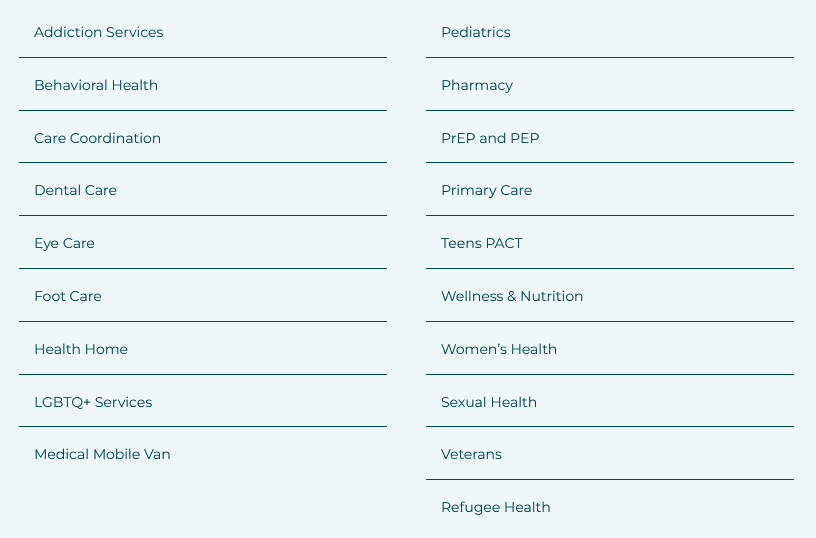

#### Summary

As these facilities are essentially meant to serve the broad health needs of those without access to healthcare, these are relevant to healthcare accessibility, but it may be difficult to incorporate these due to their variable locations. 

### 14. Hospice

These faciltiies focus on providing a good quality of life for those who are approaching the end of their lives. Given this narrow focus/the clear lack of walk-in ability, these can be ignored when calculating healthcare accessibility.

In [122]:
nyc_hospitals[nyc_hospitals["Description"] == "Hospice"].head(3)

,Facility ID,Facility Name,Short Description,Description,Facility Open Date,Facility Address 1,Facility Address 2,Facility City,Facility State,Facility Zip Code,...,Cooperator Address 2,Cooperator City,Cooperator State,Cooperator Zip Code,Ownership Type,Facility Latitude,Facility Longitude,Facility Location,geometry,dist_from_nyc
366,3918,Jansen Hospice and Palliative Care,HSPC,Hospice,04/20/1988,670 White Plains Road,Suite 213,Scarsdale,New York,10583,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.969849,-73.806931,"(40.969849, -73.806931)",POINT (-73.80693 40.96985),30573.395657
2274,7805,Calvary Home Health Agency and Hospice Care,HSPC,Hospice,01/14/1999,1740 Eastchester Road,NaN,Bronx,New York,10461,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.847294,-73.844658,"(40.847294, -73.844658)",POINT (-73.84466 40.84729),17698.081998
2673,4039,"MJHS Hospice and Palliative Care, Inc.",HSPC,Hospice,06/09/1988,"39 Broadway, Suite 200",NaN,New York,New York,10006,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.706333,-74.012939,"(40.706333, -74.012939)",POINT (-74.01294 40.70633),3471.686747


### 15. Long Term Home Health Care Program

Coordinated plan of medical, nursing, and rehabilitative care provided at home to disabled persons who are medically eligible for placement in a nursing home
Offers patients an alternative to institutionalization

(https://www.health.ny.gov/health_care/medicaid/program/longterm/lthhc.htm)

In [123]:
nyc_hospitals[nyc_hospitals["Description"] == "Long Term Home Health Care Program"].head(3)

,Facility ID,Facility Name,Short Description,Description,Facility Open Date,Facility Address 1,Facility Address 2,Facility City,Facility State,Facility Zip Code,...,Cooperator Address 2,Cooperator City,Cooperator State,Cooperator Zip Code,Ownership Type,Facility Latitude,Facility Longitude,Facility Location,geometry,dist_from_nyc
326,2966,Visiting Nurse Service of New York Home Care,LTHHCP,Long Term Home Health Care Program,01/15/2002,1250 Broadway,NaN,New York,New York,10001,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.747776,-73.988197,"(40.747776, -73.988197)",POINT (-73.98820 40.74778),1766.576197
998,3618,NYU Winthrop Hospital,LTHHCP,Long Term Home Health Care Program,07/18/1986,290 Old Country Road,NaN,Mineola,New York,11501,...,NaN,New York,New York,10016.0,Not for Profit Corporation,40.738190,-73.643799,"(40.73819, -73.643799)",POINT (-73.64380 40.73819),29190.880234
1527,8513,United Odd Fellow and Rebekah Home LTHHCP,LTHHCP,Long Term Home Health Care Program,10/04/2007,1040 Havemeyer Avenue,NaN,Bronx,New York,10462,...,NaN,NaN,New York,NaN,Not for Profit Corporation,40.828777,-73.847130,"(40.828777, -73.84713)",POINT (-73.84713 40.82878),16116.274001


#### Summary

Like with hte previous section, these are very narrow in scope and don't necessarily affect healthcare accessibility and its more generic, on-demand nature. Therefore, this category can be ignored when calculating healthcare accessibility. 

### 16. Adult Day Health Care Program - Offsite

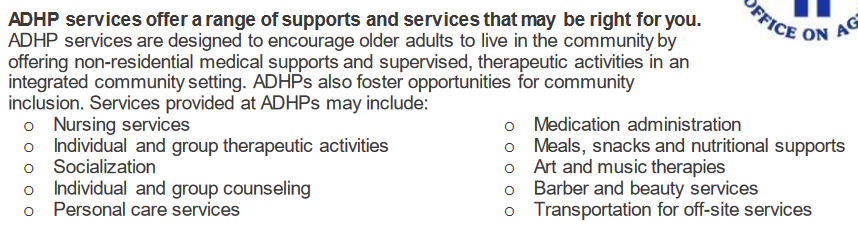

(https://dhcf.dc.gov/sites/default/files/dc/sites/dhcf/page_content/attachments/ADHP_091318_CLEAN.pdf)

In [132]:
nyc_hospitals[nyc_hospitals["Description"] == "Adult Day Health Care Program - Offsite"].head(3)

,Facility ID,Facility Name,Short Description,Description,Facility Open Date,Facility Address 1,Facility Address 2,Facility City,Facility State,Facility Zip Code,...,Cooperator Address 2,Cooperator City,Cooperator State,Cooperator Zip Code,Ownership Type,Facility Latitude,Facility Longitude,Facility Location,geometry,dist_from_nyc
146,7582,Forest View Adult Day Health Care Center,ADHCP,Adult Day Health Care Program - Offsite,07/10/1998,457 Dougherty Boulevard,NaN,Inwood,New York,11696,...,NaN,NaN,New York,NaN,Business Corporation,40.625426,-73.746696,"(40.625426, -73.746696)",POINT (-73.74670 40.62543),23671.642339
179,7743,Fairview Adult Day Care Center,ADHCP,Adult Day Health Care Program - Offsite,04/15/1999,1444 E 99 St,NaN,Brooklyn,New York,11236,...,NaN,NaN,New York,NaN,Business Corporation,40.635677,-73.889084,"(40.635677, -73.889084)",POINT (-73.88908 40.63568),13633.875640
548,7661,Bainbridge Nrsg&Rehab Center ADHCP,ADHCP,Adult Day Health Care Program - Offsite,10/27/1998,3089-3099 Ocean Avenue,NaN,Brooklyn,New York,11235,...,NaN,NaN,New York,NaN,LLC,40.585888,-73.948776,"(40.585888, -73.948776)",POINT (-73.94878 40.58589),16570.752711


#### Summary

These facilities are geared more for "day care" rather than any more strictly medical activities, so these aren't relevant when calculating medical accessibility.

## Validation of data completeness

In [136]:
for x in nyc_hospitals["Facility Name"].values:
    print(x)

The Riverside
Barnabas Hospital Methadone
Sheepshead Bay Surgery Center
Mobile Medical Unit
Parkmed NYC, LLC
New Alternatives for Children Inc.
Addus Homecare
Vista on 5th
CenterLight Healthcare D&TC
Beth Abraham Center for Rehabilitation and Nursing
NYU College of Dentistry - Brooklyn
Inspir Carnegie Hill
PS 457
Rogosin Kidney Center
PS 171 Patrick Henry Preparatory School
Life Care Services, Inc.
Corona Health Center
PS 155
PS 83 Mendoza School
L & G Home Care Agency
North Central Bronx Hospital
Assisted Living at Jennings Hall
South Beach Psychiatric Center
The Fountains at RiverVue
Dhcare Homehealth Inc.
Lower Manhattan Dialysis Center-2
C.I.S. 303
Rogosin Kidney Center-Bklyn Dialysis
Joseph P. Addabbo Family Health Center
Universal Home Care Agency Of New York Inc.
Mount Sinai Morningside
A Caring Hand, Inc.
Acute Care Experts Inc
Grupp Ii, Inc.
BMS at Genesis
Samaritan Health Village 53rd St
Long Life Home Care Inc
Bronx Dialysis Center
Jzanus Home Care Inc.
Jsp. Life Agency Inc.

In [137]:
arcgis_urgentcare = gpd.read_file("data/UrgentCareFacilities.gdb/")
arcgis_urgentcare.head()

,ID,NAME,ADDRESS,ADDRESS2,CITY,STATE,ZIP,COUNTY,FIPS,DIRECTIONS,NAICSCODE,NAICSDESCR,GEOPREC,PHONELOC,PHONE,ZIP4,LONGITUDE,LATITUDE,geometry
0,10193191,FAIRBANKS URGENT CARE CENTER,1867 AIRPORT WAY,SUITE 130B,FAIRBANKS,AK,99701,FAIRBANKS NORTH STAR,02090,LOCATED ON THE SOUTH SIDE OF AIRPORT WAY (SOUT...,621493,URGENT MEDICAL CARE CENTERS AND CLINICS (EXCEP...,ONENTITY,YES,(907) 452-2178,4056,-147.756405,64.835818,POINT (-147.75640 64.83582)
1,10421243,1ST CARE,1101 NOBLE STREET,NOT AVAILABLE,FAIRBANKS,AK,99701,FAIRBANKS NORTH STAR,02090,LOCATED ON THE EAST SIDE OF NOBLE STREET BETWE...,621493,URGENT MEDICAL CARE CENTERS AND CLINICS (EXCEP...,ONENTITY,YES,(907) 458-2682,4924,-147.713357,64.838565,POINT (-147.71336 64.83857)
2,10844602,ROCKWOOD - CHENEY MEDICAL CENTER,19 NORTH 7TH STREET,NOT AVAILABLE,CHENEY,WA,99004,SPOKANE,53063,LOCATED ON THE NE CORNER OF NORTH 7TH STREET A...,621493,URGENT MEDICAL CARE CENTERS AND CLINICS (EXCEP...,ONENTITY,YES,(509) 235-6151,2220,-117.577696,47.493125,POINT (-117.57770 47.49313)
3,10844607,ROCKWOOD - NORTH CLINIC,9001 NORTH COUNTRY HOMES BOULEVARD,NOT AVAILABLE,SPOKANE,WA,99218,SPOKANE,53063,LOCATED ON THE NE CORNER OF NORTH COUNTRY HOME...,621493,URGENT MEDICAL CARE CENTERS AND CLINICS (EXCEP...,ONENTITY,YES,(509) 744-1700,2072,-117.415760,47.739681,POINT (-117.41576 47.73968)
4,10425848,VANCOUVER CLINIC - SALMON CREEK SAME DAY SERVICES,2525 NE 139TH STREET,NOT AVAILABLE,VANCOUVER,WA,98686,CLARK,53011,LOCATED AT THE SE CORNER OF NE 139TH STREET AN...,621493,URGENT MEDICAL CARE CENTERS AND CLINICS (EXCEP...,ONENTITY,YES,(360) 397-3970,2719,-122.644800,45.720730,POINT (-122.64480 45.72073)


In [138]:
arcgis_urgentcare["dist_from_nyc"] = arcgis_urgentcare["geometry"].apply(lambda x: geod.geometry_length(shp.geometry.LineString([x, shp.Point(loc[::-1])])))
arcgis_urgentcare["dist_from_nyc"].describe()

count    4.810000e+03
mean     1.876474e+06
std      1.299106e+06
min      1.848483e+03
25%      8.806649e+05
50%      1.550283e+06
75%      2.748149e+06
max      8.012373e+06
Name: dist_from_nyc, dtype: float64

In [150]:
# only 53 entries within 32km from manhattan
arcgis_urgentcare_nyc = arcgis_urgentcare[(arcgis_urgentcare["dist_from_nyc"] <= 32000) & (arcgis_urgentcare["STATE"] == "NY")]
arcgis_urgentcare_nyc.head()

,ID,NAME,ADDRESS,ADDRESS2,CITY,STATE,ZIP,COUNTY,FIPS,DIRECTIONS,NAICSCODE,NAICSDESCR,GEOPREC,PHONELOC,PHONE,ZIP4,LONGITUDE,LATITUDE,geometry,dist_from_nyc
3002,10194027,STAT MD PROFESSIONAL LIMITED LIABILITIES COMPANY,2029 JERICHO TURNPIKE,NOT AVAILABLE,NEW HYDE PARK,NY,11040,NASSAU,36059,NORTH OF JERICHO TURNPIKE BETWEEN LEONARD BOUL...,621493,URGENT MEDICAL CARE CENTERS AND CLINICS (EXCEP...,ONENTITY,YES,(516) 352-7828,4720,-73.673968,40.735974,POINT (-73.67397 40.73597),26638.440781
3011,11513047,NORTHERN URGENT CARE CENTER,164-18 NORTHERN BOULEVARD,NOT AVAILABLE,FLUSHING,NY,11358,QUEENS,36081,LOCATED ON THE SW SIDE OF NORTHERN BOULEVARD B...,621493,URGENT MEDICAL CARE CENTERS AND CLINICS (EXCEP...,ONENTITY,YES,(718) 939-5900,2647,-73.801776,40.760248,POINT (-73.80178 40.76025),16145.505465
3012,11513029,RAPID MEDICAL CENTER,3316 BROADWAY,NOT AVAILABLE,LONG ISLAND CITY,NY,11106,QUEENS,36081,LOCATED ON THE SW SIDE OF BROADWAY BETWEEN 33R...,621493,URGENT MEDICAL CARE CENTERS AND CLINICS (EXCEP...,ONENTITY,YES,(718) 626-6010,1806,-73.923338,40.760830,POINT (-73.92334 40.76083),6429.460912
3051,10470823,NASSAU IMMEDIATE MEDICAL CARE,465 WILLIS AVENUE,NOT AVAILABLE,WILLISTON PARK,NY,11596,NASSAU,36059,WEST OF WILLIS AVENUE BETWEEN HILLSIDE AVENUE ...,621493,URGENT MEDICAL CARE CENTERS AND CLINICS (EXCEP...,ONENTITY,YES,(516) 294-3535,1724,-73.645556,40.756488,POINT (-73.64556 40.75649),29158.356797
3148,10844026,QUICK DOCS,255 EAST 98TH STREET,NOT AVAILABLE,BROOKLYN,NY,11212,KINGS,36047,NE CORNER OF EAST 98TH STREET AND HOWARD AVENUE,621493,URGENT MEDICAL CARE CENTERS AND CLINICS (EXCEP...,ONENTITY,YES,(718) 240-2673,8817,-73.918658,40.661457,POINT (-73.91866 40.66146),9838.348409


In [151]:
for name in arcgis_urgentcare_nyc["NAME"].values:
    print(name)

STAT MD PROFESSIONAL LIMITED LIABILITIES COMPANY
NORTHERN URGENT CARE CENTER
RAPID MEDICAL CENTER
NASSAU IMMEDIATE MEDICAL CARE
QUICK DOCS
DELTA MEDICAL CENTER
THROGS NECK URGENT MEDICAL CARE PRIMARY CARE
FIRSTCARE WALK IN MEDICAL CLINIC
HEMPSTEAD MAINE MEDICAL CENTER
FIRST MED IMMEDIATE MEDICAL SERVICES OF QUEENS
WE CARE WALK IN MEDICAL CENTER
OPPORTUNITY DEVELOPMENT ASSOCIATION PRIMARY HEALTH CARE CENTER INCORPORATED
BETH ISRAEL MEDICAL GROUP
FOREST URGENT CARE CENTER
HEALTH CHECK
GARDEN CITY URGENT MEDICAL CARE
FIRST MED URGENT CARE
FLATLANDS MEDICAL AND URGENT CARE
IMMEDIATE MEDICAL CARE
BISHOP ORRIS MEDICAL CENTER URGENT CARE
FIRST MED IMMEDIATE MEDICAL SERVICES OF QUEENS
NEW YORK MEDICAL AND DIAGNOSTIC CENTER INCORPORATED
HEARTLAND MEDICAL WALK-IN CARE
STATCARE MEDICAL PROFESSIONAL LIMITED LIABILITY COMPANY
WESTSIDE MEDICAL CENTER


It seems that, when manually checking matches/mismatches between the two, the heatlh facility general information dataset doesn't seem to contain any urgent care facilities, which is problematic as these are relevant to heatlhcare accessibility. 

This dataset contains the locations of Article 28, Article 36, Article 40, and Article 7 health care facilities and programs from the Health Facilities Information System (HFIS). Article 28 facilities are hospitals, nursing homes, diagnostic treatment centers and midwifery birth centers. Article 36 facilities are certified home health care agencies, licensed home care services agencies, and long term home health care programs. Article 40 facilities are hospices. Article 7 are licensed adult care facilities. (https://health.data.ny.gov/Health/Health-Facility-General-Information/vn5v-hh5r)

(doesn't include urgent care centers)

In [143]:
arcgis_hospitals = pd.read_csv("data/Hospitals.csv")
arcgis_hospitals

,X,Y,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,...,VAL_DATE,WEBSITE,STATE_ID,ALT_NAME,ST_FIPS,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD
0,-86.494549,31.295795,1,1336420,ANDALUSIA HEALTH,"849 SOUTH THREE NOTCH STREET, PO BOX 760",ANDALUSIA,AL,36420,NOT AVAILABLE,...,2014/02/10 00:00:00+00,http://www.andalusiaregionalhospital.com,H2001,NOT AVAILABLE,1,PROPRIETARY,-999,88,LEVEL III,Y
1,-86.978407,34.804164,2,1535611,ATHENS LIMESTONE HOSPITAL,700 WEST MARKET STREET,ATHENS,AL,35611,NOT AVAILABLE,...,2013/10/02 00:00:00+00,http://www.athenslimestonehospital.com,H4201,NOT AVAILABLE,1,PROPRIETARY,-999,71,LEVEL III,N
2,-87.478799,31.017024,3,136502,ATMORE COMMUNITY HOSPITAL,401 MEDICAL PARK DR,ATMORE,AL,36502,NOT AVAILABLE,...,2014/02/10 00:00:00+00,http://www.ebaptisthealthcare.org/atmorecommun...,H2704,NOT AVAILABLE,1,NON-PROFIT,-999,51,LEVEL III,Y
3,-86.174930,32.376399,4,236124,BAPTIST MEDICAL CENTER EAST,"400 TAYLOR ROAD, PO BOX 241267",MONTGOMERY,AL,36117,1267,...,2013/09/03 00:00:00+00,http://www.baptistfirst.org,H5107,NOT AVAILABLE,1,GOVERNMENT - DISTRICT/AUTHORITY,-999,150,NOT AVAILABLE,Y
4,-86.277549,32.328154,5,1736111,BAPTIST MEDICAL CENTER SOUTH,"2105 EAST SOUTH BOULEVARD, PO BOX 11010",MONTGOMERY,AL,36111,0010,...,2014/03/12 00:00:00+00,http://www.baptistfirst.org,H5102,NOT AVAILABLE,1,GOVERNMENT - DISTRICT/AUTHORITY,-999,432,LEVEL II,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8008,-74.347278,40.500067,8117,196784290,UNIVERSITY HOSPITAL,97 SUNFIELD AVENUE,EDISON,NJ,8837,NOT AVAILABLE,...,2022/04/07 00:00:00+00,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,34,NOT AVAILABLE,-999,-999,NOT AVAILABLE,NOT AVAILABLE
8009,-104.754827,38.968781,8118,196784298,CHILDREN'S HOSPITAL OF COLORADO - COLORADO SPR...,4090 BRIARGATE PARKWAY,COLORADO SPRINGS,CO,80920,NOT AVAILABLE,...,2022/04/07 00:00:00+00,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,8,NOT AVAILABLE,-999,-999,NOT AVAILABLE,Y
8010,-91.219417,30.266626,8119,196784302,OCHSNER MEDICAL COMPLEX IBERVILLE,25455 LA-1,PLAQUEMINE,LA,70764,NOT AVAILABLE,...,2022/04/07 00:00:00+00,NOT AVAILABLE,NOT AVAILABLE,NOT AVAILABLE,22,NOT AVAILABLE,-999,-999,NOT AVAILABLE,Y
8011,-83.811348,39.939755,8120,196784919,MERCY HEALTH FOUNTIAN MEDICAL CAMPUS,100 W MCCREIGHT AVE,SPRINGFIELD,OH,45504,NOT AVAILABLE,...,2022/05/02 00:00:00+00,https://www.mercy.com/,NOT AVAILABLE,NOT AVAILABLE,39,PROPRIETARY,-999,-999,NOT AVAILABLE,N


In [144]:
arcgis_hospitals["geometry"] = arcgis_hospitals.apply(lambda x: shp.Point((x["LONGITUDE"], x["LATITUDE"])), axis=1)

In [145]:
arcgis_hospitals["dist_from_ny"] = arcgis_hospitals["geometry"].apply(lambda x: geod.geometry_length(shp.geometry.LineString([x, shp.Point((loc[1], loc[0]))])))
arcgis_hospitals["dist_from_ny"].describe()

count    8.013000e+03
mean     1.823892e+06
std      1.260117e+06
min      4.045355e+02
25%      9.192583e+05
50%      1.650428e+06
75%      2.445626e+06
max      1.394114e+07
Name: dist_from_ny, dtype: float64

In [153]:
arcgis_hospitals_nyc = arcgis_hospitals[(arcgis_hospitals["dist_from_ny"] <= 32000) & (arcgis_hospitals["STATE"] == "NY")]
arcgis_hospitals_nyc.head()

,X,Y,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,...,STATE_ID,ALT_NAME,ST_FIPS,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD,geometry,dist_from_ny
4197,-73.643008,40.740697,4288,120511501,NYU LANGONE HOSPITAL - LONG ISLAND,259 FIRST STREET,MINEOLA,NY,11501,NOT AVAILABLE,...,7002053H,NYU LANGONE HOSPITALS,36,NON-PROFIT,-999,591,LEVEL I,N,POINT (-73.6430084 40.74069748),29265.078529
4198,-73.631604,40.688513,4289,6811530,MERCY HOSPITAL,1000 NORTH VILLAGE AVENUE,ROCKVILLE CENTRE,NY,11570,NOT AVAILABLE,...,2909000H,MERCY MEDICAL CENTER,36,NON-PROFIT,-999,375,NOT AVAILABLE,N,POINT (-73.63160381 40.68851303),30605.288895
4199,-73.686299,40.681128,4290,6311580,LONG ISLAND JEWISH VALLEY STREAM,900 FRANKLIN AVENUE,VALLEY STREAM,NY,11580,NOT AVAILABLE,...,7003004H,LONG ISLAND JEWISH MEDICAL CENTER,36,NON-PROFIT,-999,284,NOT AVAILABLE,N,POINT (-73.6862992 40.6811275),26216.571101
4200,-73.630839,40.650998,4291,7011510,MOUNT SINAI SOUTH NASSAU,1 HEALTHY WAY,OCEANSIDE,NY,11572,NOT AVAILABLE,...,2950001H,SOUTH NASSAU COMMUNITIES HOSPITAL INC,36,NON-PROFIT,-999,455,LEVEL II,N,POINT (-73.63083944 40.650998),31600.556504
4202,-73.701611,40.777636,4293,6411030,NORTH SHORE UNIVERSITY HOSPITAL,300 COMMUNITY DRIVE,MANHASSET,NY,11030,NOT AVAILABLE,...,2951001H,NORTH SHORE UNIVERSITY HOSPITAL INC,36,NON-PROFIT,-999,756,LEVEL I,Y,POINT (-73.70161094 40.77763592),24817.400525


In [154]:
for name in arcgis_hospitals_nyc["NAME"].values:
    print(name)

NYU LANGONE HOSPITAL - LONG ISLAND
MERCY HOSPITAL
LONG ISLAND JEWISH VALLEY STREAM
MOUNT SINAI SOUTH NASSAU
NORTH SHORE UNIVERSITY HOSPITAL
ST. FRANCIS HOSPITAL AND HEART CENTER
MONTEFIORE MOUNT VERNON HOSPITAL
MONTEFIORE NEW ROCHELLE HOSPITAL
SJRH - ST JOHNS DIVISION
ST. JOSEPH'S MEDICAL CENTER
SJRH - PARK CARE PAVILION
NEW YORK - PRESBYTERIAN LAWRENCE HOSPITAL
BRONXCARE HOSPITAL CENTER
JACOBI MEDICAL CENTER
MONTEFIORE MEDICAL CENTER - WAKEFIELD HOSPITAL
MONTEFIORE MEDICAL CENTER - HENRY AND LUCY MOSES DIV
LINCOLN MEDICAL AND MENTAL HEALTH CENTER
CALVARY HOSPITAL INC
SBH HEALTH SYSTEM
BRONXCARE HOSPITAL CENTER
MONTEFIORE MEDICAL CENTER - MONTEFIORE WESTCHESTER SQUARE
NORTH CENTRAL BRONX HOSPITAL
BROOKDALE HOSPITAL MEDICAL CENTER
BROOKLYN HOSPITAL CENTER - DOWNTOWN CAMPUS
NEW YORK COMMUNITY HOSPITAL OF BROOKLYN, INC
CONEY ISLAND HOSPITAL
KINGS COUNTY HOSPITAL CENTER
NYU LANGONE HOSPITAL - BROOKLYN
MAIMONIDES MEDICAL CENTER
NEW YORK - PRESBYTERIAN BROOKLYN METHODIST HOSPITAL
INTERFAITH 

Overall, matches seem to be much more cmomon between this hospiatls dataset and the heatlh facility general information dataset, which could be due to the fact that the latter incorporates hospitals into it. There are still a few mismatches, though

In [155]:
nyc_health_df = pd.read_csv("data/NYC_Health___Hospitals_patient_care_locations_-_2011.csv")
nyc_health_df

,Facility Type,Borough,Facility Name,Cross Streets,Phone,Location 1,Postcode,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,Child Health Center,Manhattan,La Clinica Del Barrio,NaN,212-410-7940,"413 120th Street\nNew York, NY 10035\n(40.7982...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Acute Care Hospital,Queens,Elmhurst Hospital Center,NaN,718-334-4000,"79 01\nElmhurst, NY 11373\n(40.738710402563, -...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Child Health Center,Brooklyn,Ida G. Israel Community Health Center,W. 22nd St. & W. 23rd St.,718-946-3400,"2201 Neptune Avenue\nBrooklyn, NY 11224\n(40.5...",11224.0,40.578468,-73.989614,13.0,47.0,348.0,3188417.0,3.069900e+09,Seagate-Coney Island ...
3,Child Health Center,Queens,South Queens Community Health Center,NaN,718-883-6699,"114 02 Guy R Brewer Blvd\nJamaica, NY 11434\n(...",11434.0,40.688615,-73.785593,12.0,28.0,276.0,4264631.0,4.122000e+09,Baisley Park ...
4,Child Health Center,Bronx,Melrose Houses Child Health Clinic,between Morris Ave. & Courtlandt Ave.,718-292-2820,"348 156th Street\nBronx, NY 10451\n(40.8213011...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,Child Health Center,Brooklyn,Bushwick Community Health Center,NaN,718-919-1200,"1420 Bushwick Avenue\nBrooklyn, NY 11207\n(40....",11207.0,40.684318,-73.909056,4.0,37.0,403.0,3080067.0,3.034440e+09,Bushwick South ...
74,Child Health Center,Manhattan,Bellevue Hospital Center,NaN,212-562-4141,"462 First Avenue\nNew York, NY 10016\n(40.7396...",10016.0,40.739173,-73.976862,6.0,4.0,62.0,1086515.0,1.009620e+09,Murray Hill-Kips Bay ...
75,Child Health Center,Queens,Ridgewood Communicare Clinic,between Woodbine St. & Madison St.,718-334-6190,"769 Onderdonk Avenue\nRidgewood, NY 11385\n(40...",11385.0,40.702972,-73.905489,5.0,34.0,549.0,4083018.0,4.034700e+09,Ridgewood ...
76,Child Health Center,Manhattan,Smith Communicare Health Center,corner of Catherine St.,212-346-0500,"60 Madison Street\nNew York, NY 10038\n(40.711...",10038.0,40.712019,-73.997309,3.0,1.0,25.0,1077421.0,1.001110e+09,Chinatown ...


In [156]:
for name in nyc_health_df["Facility Name"].values:
    print(name)

La Clinica Del Barrio
Elmhurst Hospital Center
Ida G. Israel Community Health Center
South Queens Community Health Center
Melrose Houses Child Health Clinic
Daniel Webster Houses Child Health Clinic
Segundo Ruiz Belvis Diagnostic & Treatment Center
Parsons Communicare Clinic
Queens Hospital Center
Cumberland Diagnostic & Treatment Center
Junction Boulevard Child Health Clinic
Woodhull Medical and Mental Health Center
Eleanor Roosevelt Houses Child Health Clinic
Jacobi Medical Center
Metropolitan Hospital Center
Bushwick Communicare
Lafayette Houses Child Health Clinic
East New York Diagnostic & Treatment Center
Williamsburg Child Health Clinic
North Central Bronx Hospital
Harlem Hospital Center
Sydenham Health Center
Dr. Susan Smith McKinney Nursing and Rehabilitation Center
Lincoln  Medical &  Mental Health Center
Corona Child Health Clinic
Sea View Hospital Rehabilitation Center & Home
Springfield Gardens Medical Center
Segundo Ruiz Belvis Diagnostic & Treatment Center
Morrisania Dia

The pattern with this dataset and the heatlh facility general information dataset is basically as the previous one with the hospitals, except that this dataset covers the NYC + Health system and a few community hospitals too.